# Refined Data Visualizations
- Continuing to build on previous visualizations

## Year Over Year Price Change

In [1]:
#Loading libraries
library(ggplot2)
library(plotly)
library(RColorBrewer)
library(dplyr)
library(maps)
library(ggmap)
library(mapproj)


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.

Attaching package: ‘ggmap’

The following object is masked from ‘package:plotly’:

    wind



In [1]:
# Reading in the grouped complete metrics dataset
df = read.csv('/dsa/groups/casestudy2022su/team05/Complete_Metrics.csv')

In [7]:
# Removing outlier counts, years, prices, models
data_reduced <- df %>% filter(Count >= 20 & Year >= 2014 & Avg_Price <= 80000 & 
                               Make != 'FIAT' & Make != 'Scion' & Make != 'Mitsubishi' & Make != 'Alfa' &
                              Make != 'Maserati' & Make != 'Jaguar' & Make != 'Genesis')

In [8]:
# Removing outlier YoY price percentage change
data_reduced2 <- data_reduced %>% filter(YoY_price_pct_change >= -50)

In [9]:
# Because our YoY metrics are assigned a '0' at the newest model year I want to remove those to get a better look at 
# which makes are holding their value.
data_reduced3 <- data_reduced2 %>% filter(YoY_price_pct_change != 0)

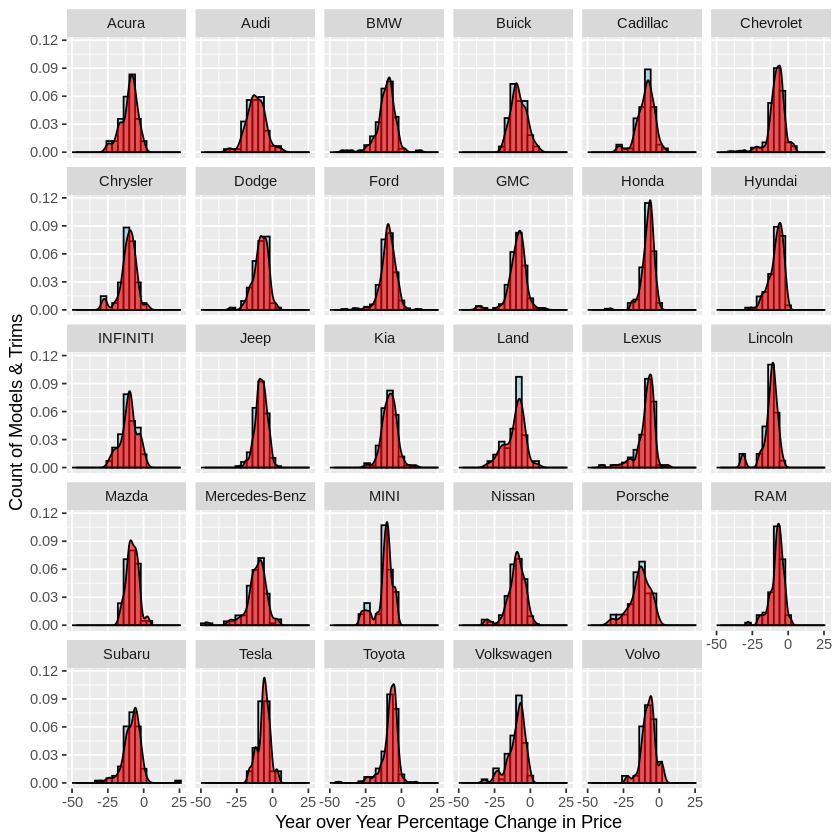

In [10]:
ggplot(data_reduced3, aes(x=YoY_price_pct_change)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="lightblue", binwidth=4) +
  facet_wrap(~Make) + labs(x= 'Year over Year Percentage Change in Price', y = 'Count of Models & Trims') +
     geom_density(alpha=.6, fill="red") 

- The above visual is a better representation of how many models & trims the respective makes have that are holding value. 0 being no change in value year over year -25 would be losing 25% year over year. Right of zero is a gain in value. 

- How many models/trims are represented for each make by year could be throwing off how accurate the above is in actually representing how they are holding value. If there are a lot more newer or older models for a given make it could skew the density plot. Newer models would naturally tend to show less year over year change and older would be opposite. 

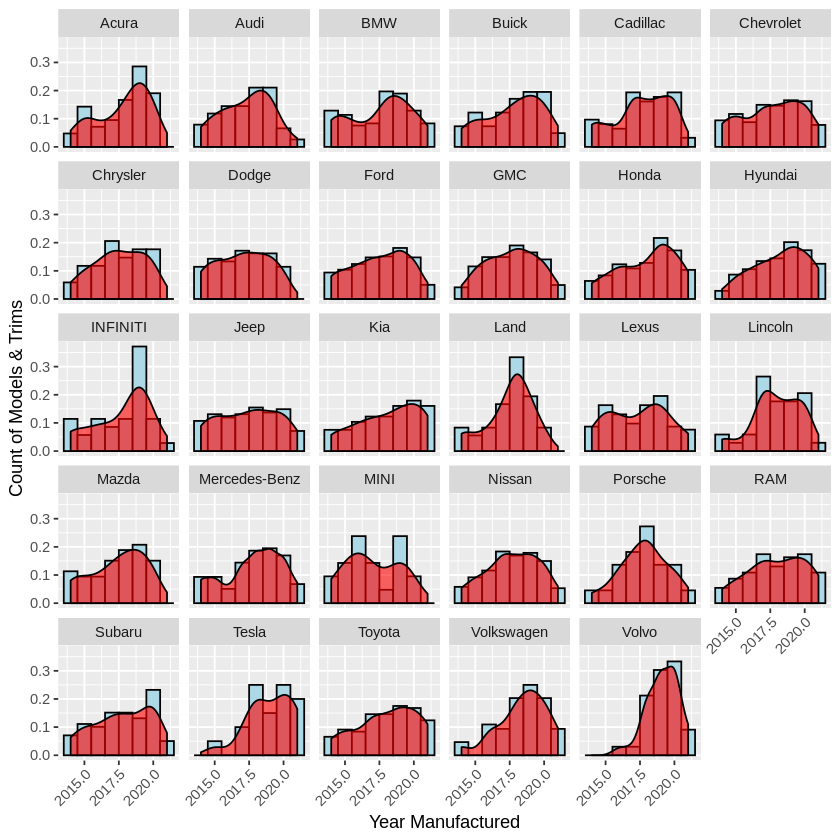

In [11]:
# Plotting the number of models/trims represented in each year for each make.
# 2014 is earliest year 2022 is newest

ggplot(data_reduced3, aes(x=Year)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="lightblue", binwidth=1) +
  facet_wrap(~Make) + labs(x= 'Year Manufactured', y = 'Count of Models & Trims') +
     geom_density(alpha=.6, fill="red") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

## Geographical Visualizations

In [12]:
# Reading in ungrouped current dataset
df2 = read.csv("/dsa/groups/casestudy2022su/team05/carscom_v03.csv")

In [13]:
# Using a function to change state names
#'x' is the column of a data.frame that holds 2 digit state codes
stateFromLower <-function(x) {
   #read 52 state codes into local variable [includes DC (Washington D.C. and PR (Puerto Rico)]
  st.codes<-data.frame(
                      state=as.factor(c("AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
                                         "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME",
                                         "MI", "MN", "MO", "MS",  "MT", "NC", "ND", "NE", "NH", "NJ", "NM",
                                         "NV", "NY", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN",
                                         "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY")),
                      full=as.factor(c("alaska","alabama","arkansas","arizona","california","colorado",
                                       "connecticut","district of columbia","delaware","florida","georgia",
                                       "hawaii","iowa","idaho","illinois","indiana","kansas","kentucky",
                                       "louisiana","massachusetts","maryland","maine","michigan","minnesota",
                                       "missouri","mississippi","montana","north carolina","north dakota",
                                       "nebraska","new hampshire","new jersey","new mexico","nevada",
                                       "new york","ohio","oklahoma","oregon","pennsylvania","puerto rico",
                                       "rhode island","south carolina","south dakota","tennessee","texas",
                                       "utah","virginia","vermont","washington","wisconsin",
                                       "west virginia","wyoming"))
                       )
     #create an nx1 data.frame of state codes from source column
  st.x<-data.frame(state=x)
     #match source codes with codes from 'st.codes' local variable and use to return the full state name
  refac.x<-st.codes$full[match(st.x$state,st.codes$state)]
     #return the full state names in the same order in which they appeared in the original source
  return(refac.x)
 
}

In [27]:
df2$State<-stateFromLower(df2$State)

In [28]:
# Reducing the number of years to only have ideally 7yrs for a given model as a maximum
df2 <- df2 %>% filter (Year >= 2016)

#Agreggating all models by state and getting an avg price
aggdata <- aggregate(df2$Avg_Price, by=list(Make=df2$Make, Model=df2$Model, State=df2$State), FUN=mean, na.rm=TRUE)

In [29]:
#Renaming the state column in both dataframes for consistency in joining
us_states <- map_data("state")
us_states <- us_states %>% rename(state = region)
aggdata <- aggdata %>% rename(state = State)

In [30]:
#Joining
us_states_carsdata <- left_join(us_states, aggdata)

Joining, by = "state"
Warning message:
“Column `state` joining character vector and factor, coercing into character vector”

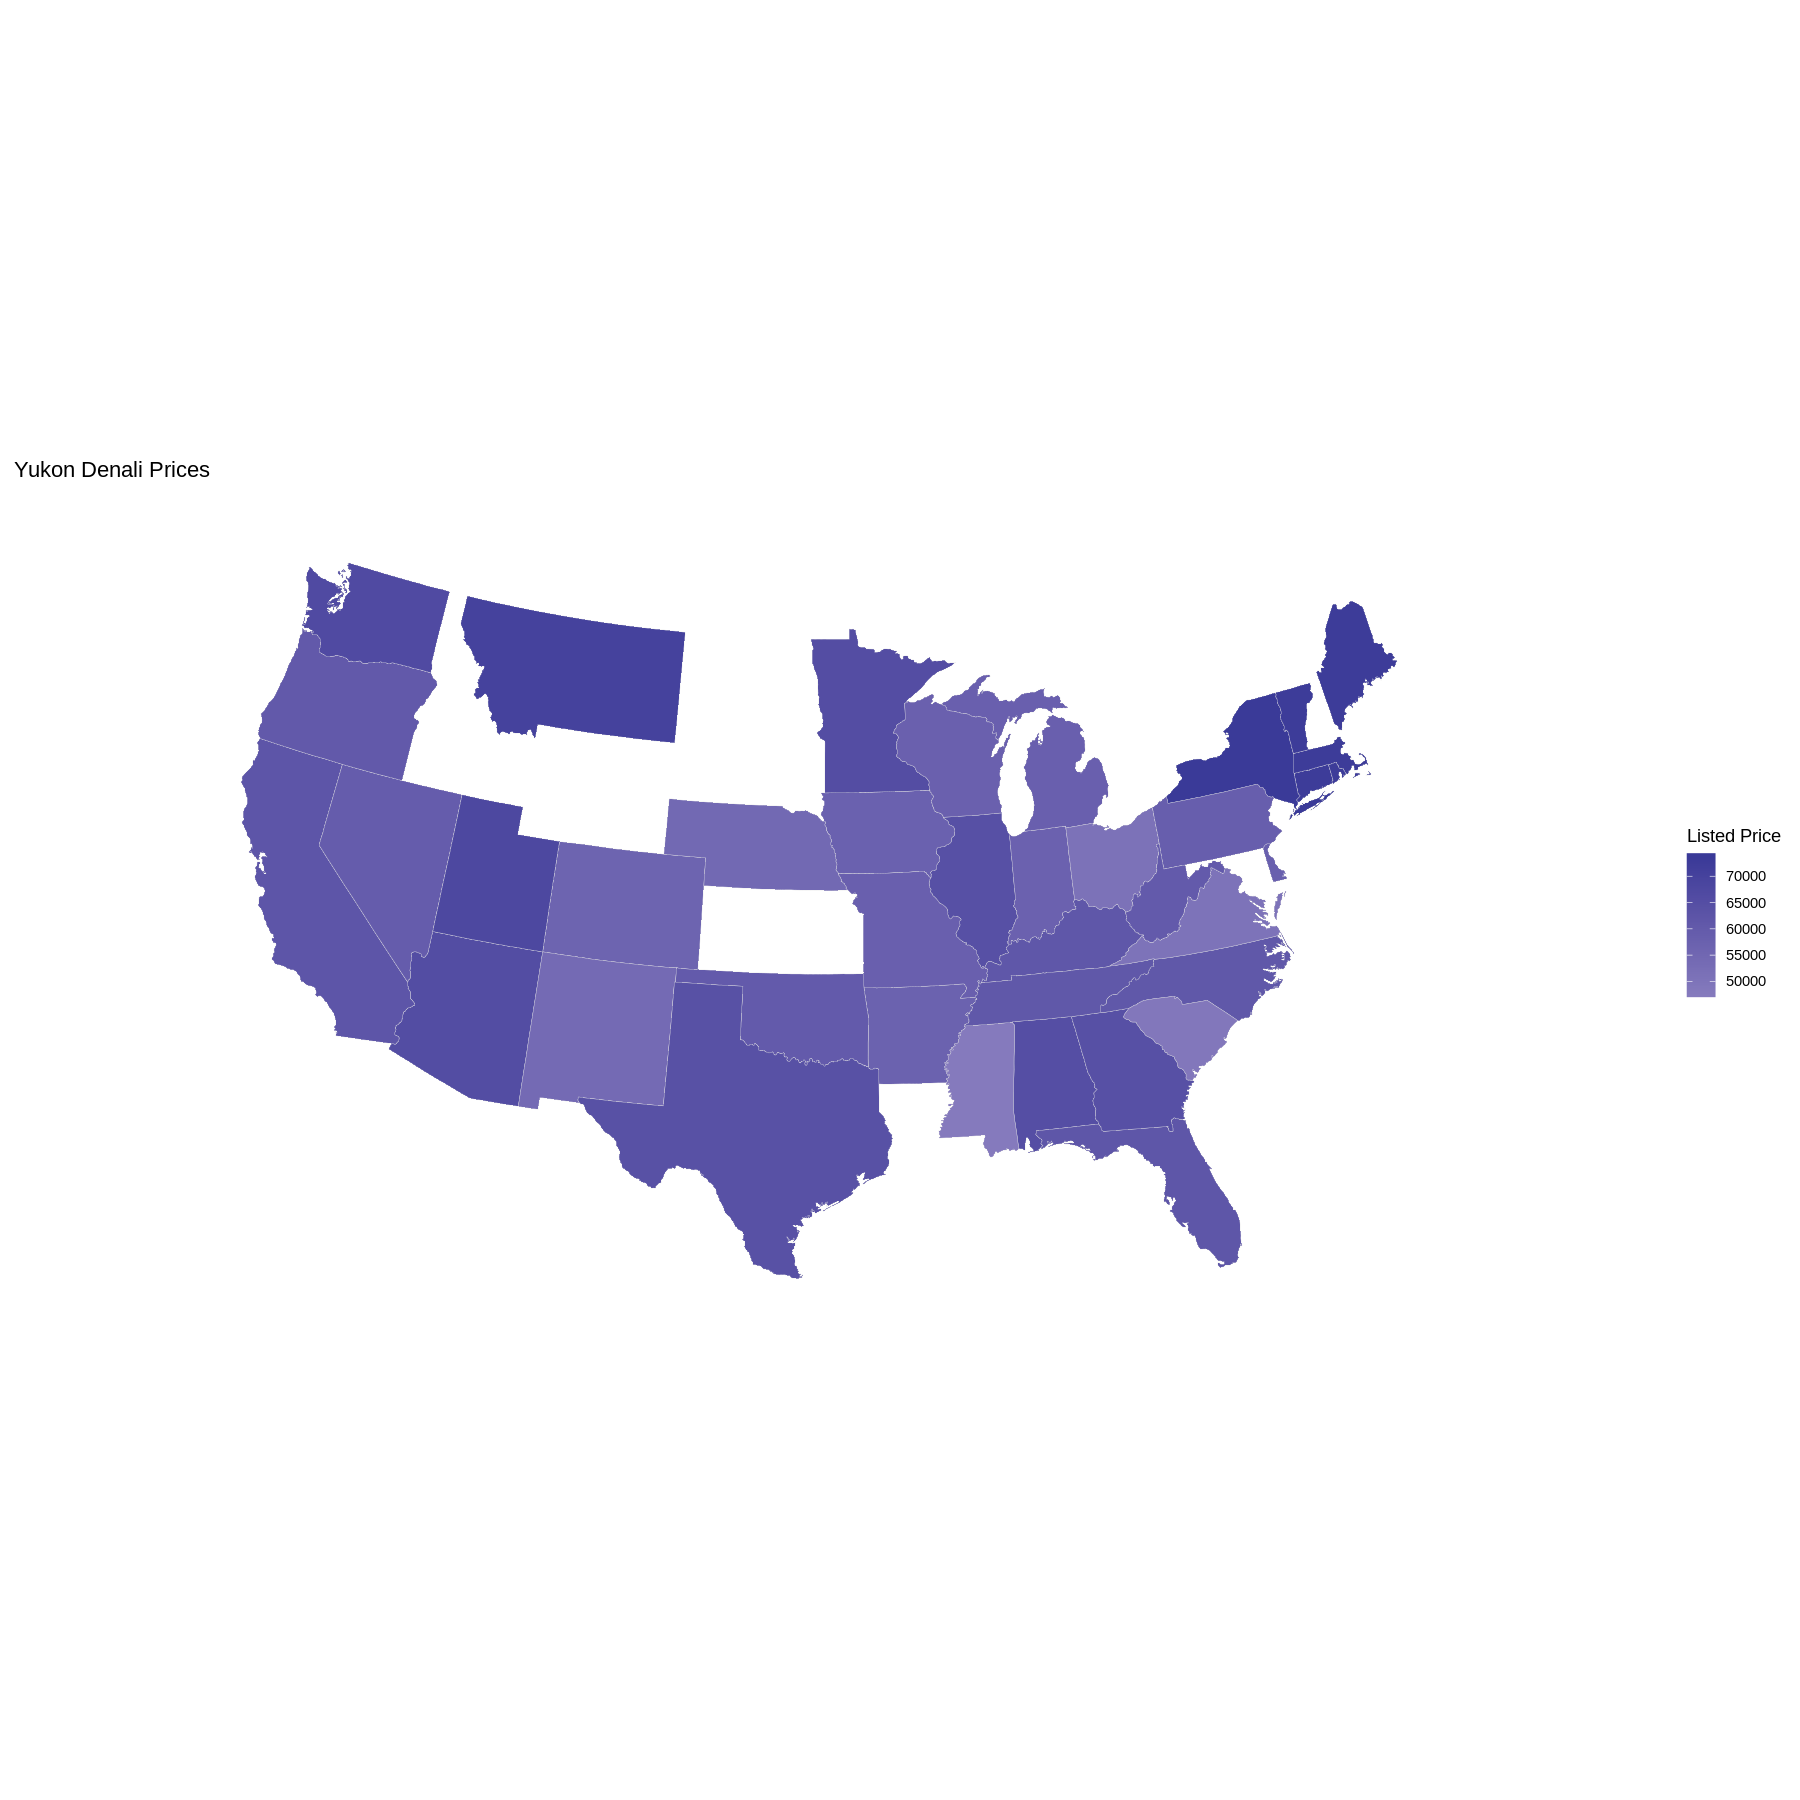

In [34]:
# Picked on Model the Yukon Denali to visualize geographically by price. 

#Making the map bigger
options(repr.plot.width = 15, repr.plot.height =15)

#Loading in data with subset
p0 <- ggplot(data = subset(us_states_carsdata,
                           Model =='Yukon Denali'),
             aes(x = long, y = lat, group = group, fill = x))

#Creating map layer
p1 <- p0 + geom_polygon(color = "gray90", size = 0.1) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) 

#Fill layer and removing background items
p2 <- p1 + scale_fill_gradient2() + theme(axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        rect = element_blank(),
        axis.title.y=element_blank(),axis.title.x=element_blank()) + labs(title = "Yukon Denali Prices") 

p2 + labs(fill = "Listed Price")


- It may be more descriptive to view the actual numbers and how they compare state to state

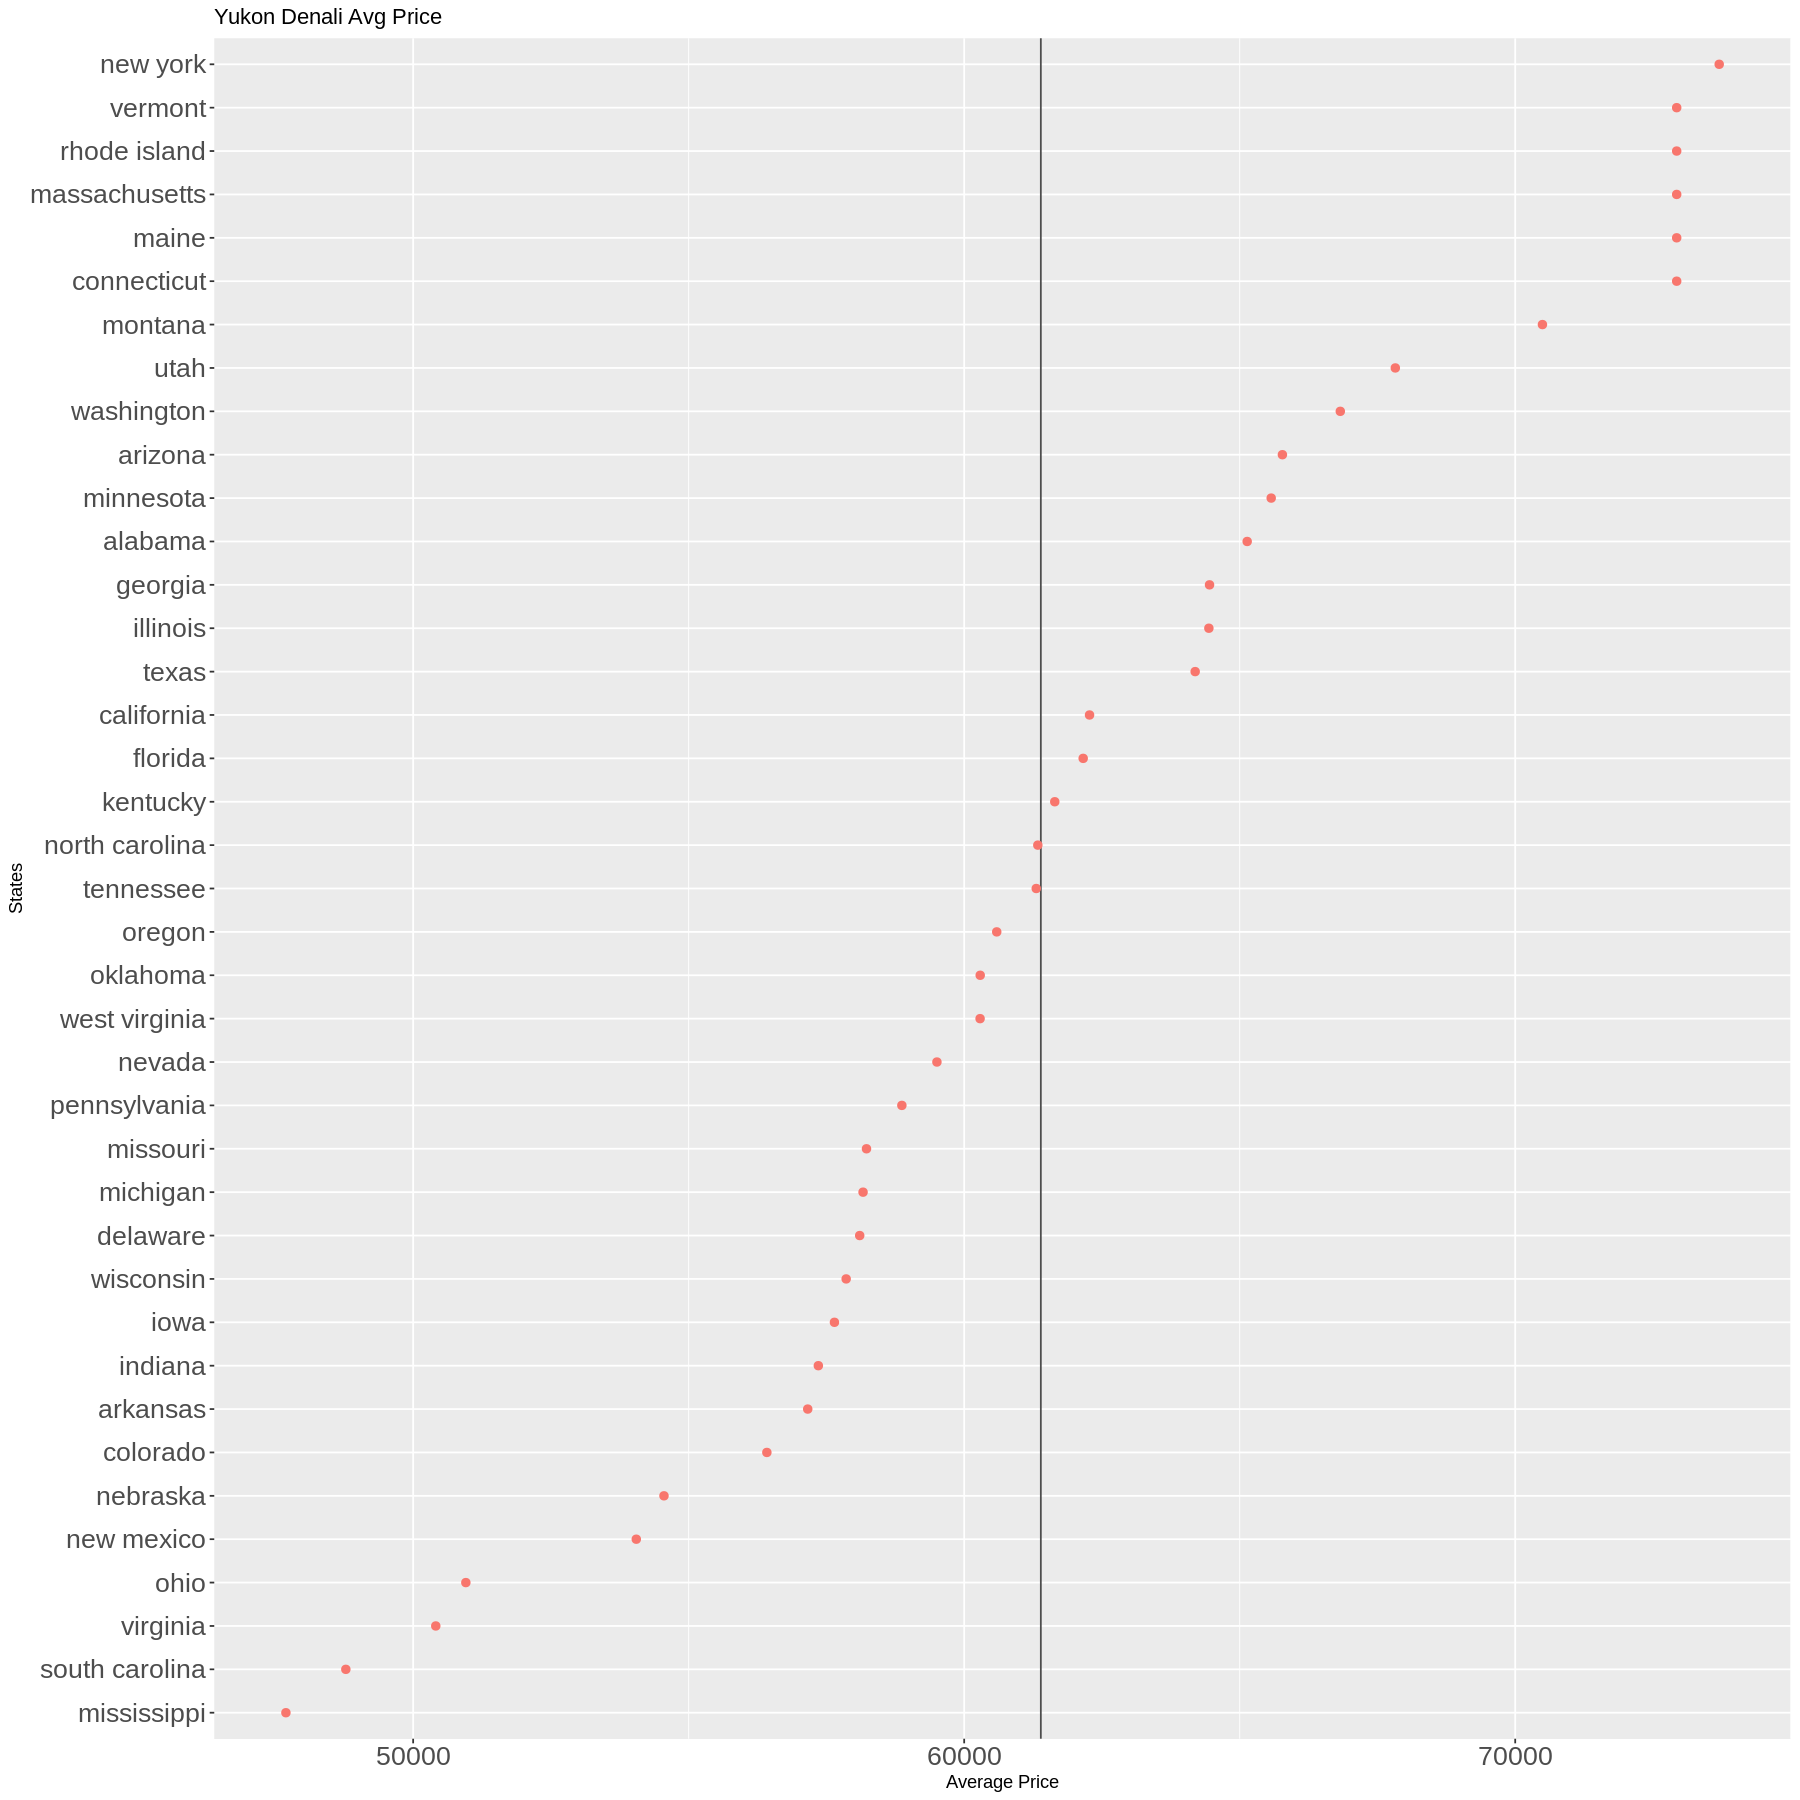

In [35]:
# Loading in data and aes
newp <- ggplot(data = subset(aggdata,
                           Model =='Yukon Denali'),
             mapping = aes(x = x,
                           y = reorder(state, x),
                          color = 'blue'))

#Making a vertical line to represent the average price across all states
newp1 <- newp + geom_vline(xintercept = 61391, color = "gray30") +
    geom_point(size = 2)

#Making pricing breaks
newp2 <- newp1 + scale_x_continuous(breaks = c(30000,40000,50000,60000,70000,80000,90000),
                              labels = c("30000", "40000", "50000", "60000",
                                         "70000", "80000", "90000"))
#Labels & aesthetics
newp2 + 
    guides(color=FALSE) + labs(x = "Average Price", y = "States") +
    theme(axis.text=element_text(size=16))+   labs(title = "Yukon Denali Avg Price") 